In [1]:
# https://github.com/borisbanushev/stockpredictionai
# https://github.com/Arturus/kaggle-web-traffic

from prepare_model_input import Input_builder
import numpy as np
import matplotlib.pyplot as plt

   Repair month  Failures
0        201603         1
1        201604         6
2        201605         3
3        201606         3
4        201607         7


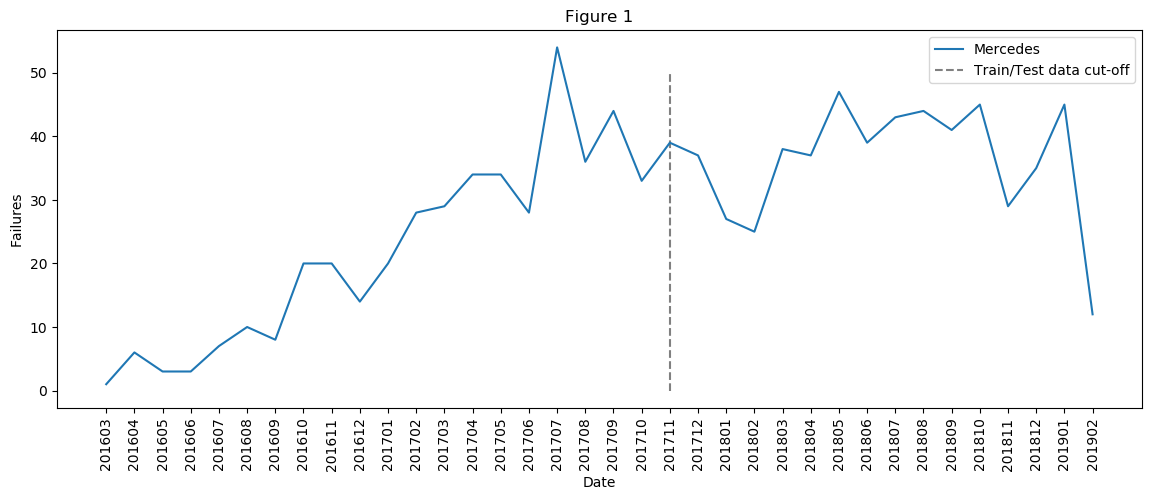

In [2]:
input_builder = Input_builder('./data/LSTM_data.csv')
examples = input_builder.examples
print(examples.head(5))
plt.figure(figsize=(14, 5), dpi=100)
plt.xticks(range(len(examples)), examples['Repair month'], rotation='vertical')
plt.plot(range(len(examples)), examples['Failures'], label='Mercedes')
plt.vlines(20, 0, 50, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Failures')
plt.title('Figure 1')
plt.legend()
plt.show()

In [3]:
# Moving Average features
examples['ma52']=examples.iloc[:,1].rolling(window=12).mean()
# Create Exponential moving average
examples['ema'] = examples.iloc[:,1].ewm(com=0.5).mean()

In [ ]:
# lagged features


                                         fft     absolute     angle
0                                  (1015+0j)  1015.000000  0.000000
1  (-190.65292361188233+201.43776916467715j)   277.354849  2.328695
2   (-48.66626839670414+160.58496856181898j)   167.797312  1.865055
3    (-72.83716857408419+7.071796769724491j)    73.179665  3.044806
4    (3.341509141062753+43.721836998768275j)    43.849341  1.494518


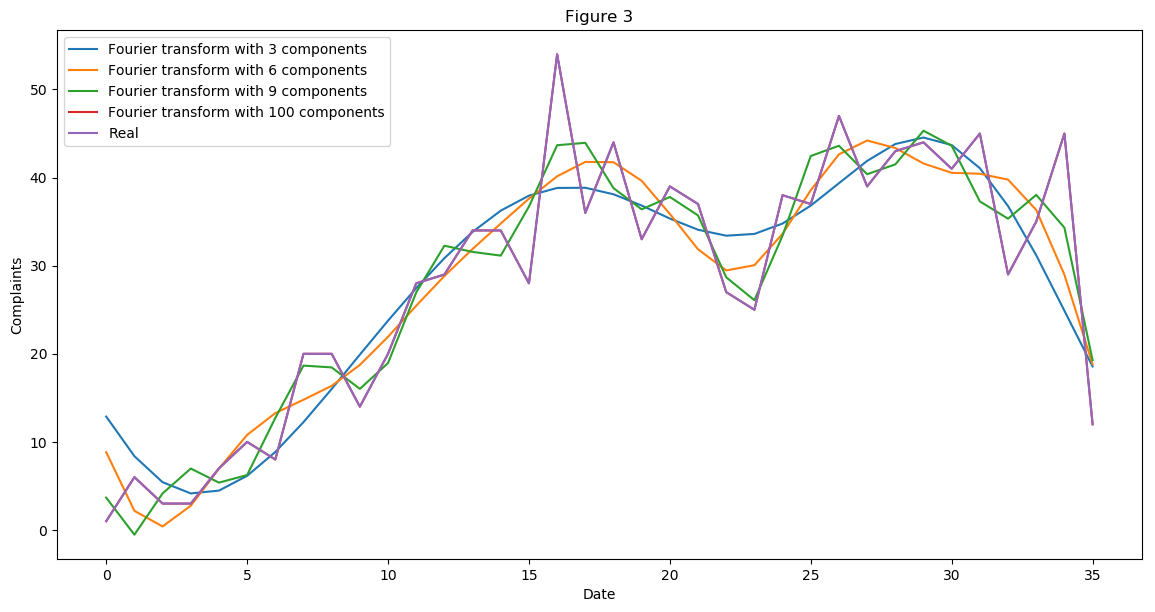

In [9]:
# Fourier transform features
import pandas as pd
close_fft = np.fft.fft(np.asarray(examples['Failures'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
print(fft_df.head(5))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(examples['Failures'],  label='Real')
plt.xlabel('Date')
plt.ylabel('Complaints')
plt.title('Figure 3')
plt.legend()
plt.show()

In [11]:
from statsmodels.tsa.arima_model import ARIMA

series = examples['Failures']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Software\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Software\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Software\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which wi

                             ARIMA Model Results                              
Dep. Variable:             D.Failures   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -123.775
Method:                       css-mle   S.D. of innovations              8.219
Date:                Wed, 20 Mar 2019   AIC                            261.551
Time:                        19:04:41   BIC                            272.438
Sample:                             1   HQIC                           265.309
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5884      0.965      0.610      0.547      -1.303       2.480
ar.L1.D.Failures    -0.7146      0.191     -3.748      0.001      -1.088      -0.341
ar.L2.D.Failures    -0.2120 

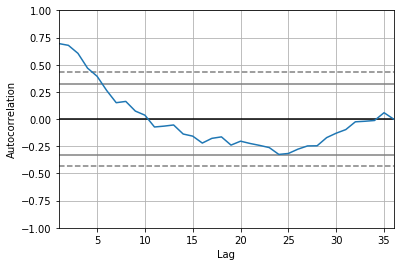

<Figure size 800x560 with 0 Axes>

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

C:\Software\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Software\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Software\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which wi

Test MSE: 135.557


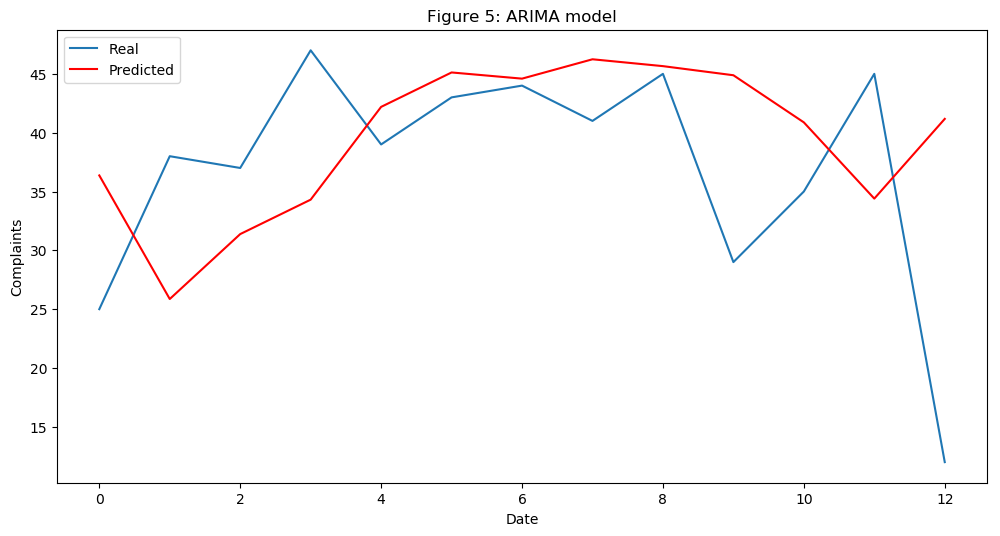

In [16]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Complaints')
plt.title('Figure 5: ARIMA model')
plt.legend()
plt.show()

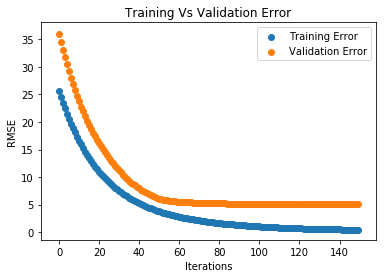

In [22]:
import xgboost as xgb

def get_feature_importance_data(dataset):
    data = dataset.copy()
    y = data['Failures']
    X = data.iloc[:, 2:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(examples)
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

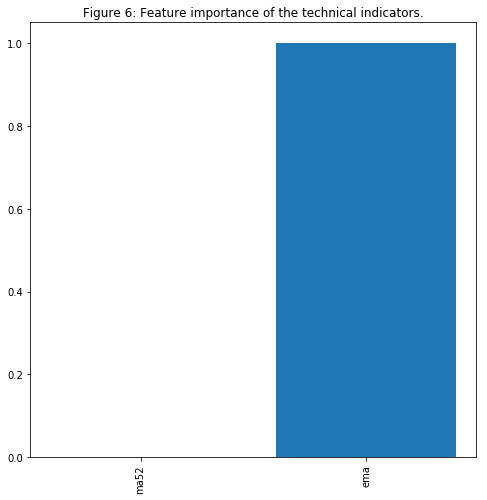

In [23]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [24]:
print(examples.head(5))

   Repair month  Failures  ma52       ema
0        201603         1   NaN  1.000000
1        201604         6   NaN  4.750000
2        201605         3   NaN  3.538462
3        201606         3   NaN  3.175000
4        201607         7   NaN  5.735537
